# Adversarial examples for CNNs

Convolutional neural networks can match or exceed human performance on various tasks such as reading mammograms (1) or when it comes to recognising differend dog breeds. Early after the start of the last deep learning wave researchers realised that CNNs are vulnerable to targeted attacks (2)(3). We will explore a few examples in this notebook.


(1) McKinney et al, [International evaluation of an AI system for breast cancer screening, 2020](https://www.nature.com/articles/s41586-019-1799-6)  
(2) Szegedy et al, [Intriguing properties of neural networks, 2013](https://arxiv.org/abs/1312.6199)  
(3) Goodfellow et al, [Explaining and Harnessing Adversarial Examples, 2014](https://arxiv.org/abs/1412.6572)

#### How can we modify and image such that it remains more or less the same for us but it can mislead a CNN?

# This notebook is super-slow on Google Colab. Run it locally!

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions 
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_VGG19

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50


from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import json

%matplotlib inline

Download the ImageNet category names. They are easier to interpret than #479 :)

In [2]:
!wget -q https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
classes = open('imagenet_class_index.json').read()
classDF = pd.DataFrame(json.loads(classes)).T.reset_index()
classDF.pop(0);
classDF.columns = ['index', 'className']

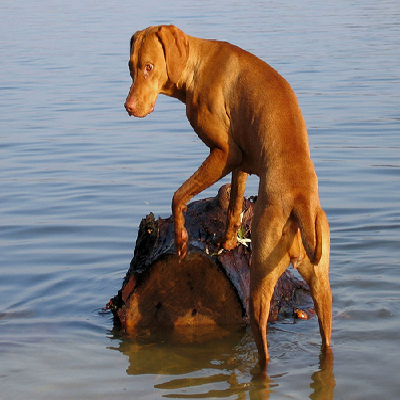

In [3]:
!wget -q -O vizsla.jpg https://upload.wikimedia.org/wikipedia/commons/8/84/Vizslaonalog.jpg
load_img('vizsla.jpg', target_size=(400, 400))

### What does pre-trained VGG16 says for this image?

In [4]:
vgg16_model = VGG16()
vizsla_img = load_img('vizsla.jpg', target_size=(224, 224))
vizsla_img = img_to_array(vizsla_img)[None]
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(vizsla_img.copy())), 10)

[[('n02100583', 'vizsla', 0.51949584),
  ('n02090379', 'redbone', 0.23726371),
  ('n02087394', 'Rhodesian_ridgeback', 0.09982837),
  ('n02093991', 'Irish_terrier', 0.09618591),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.016052403),
  ('n02088466', 'bloodhound', 0.012052266),
  ('n02107142', 'Doberman', 0.005824895),
  ('n02096051', 'Airedale', 0.0022655171),
  ('n02100877', 'Irish_setter', 0.0018373051),
  ('n02115641', 'dingo', 0.0010482876)]]

### Store predictions for each pixel's distortion

We loop over all the pixels and increase them by ~1% one-by-one. This way we create a dataset which consists of 224\*224\*3 images. For each we generate and store the predictions for all the 1000 classes. Later we will use these predictions to generate the modifier mask.

We could have used backpropagation and calculate the gradients for each pixel in one step. Here we mimic the setup where we have no access to the weights of the network, only an API connection.

**Running the cell below takes a good 10-25 minutes!**

In [5]:
def create_pred_list(original_img, preprocessor, model, bs=64):
    batch_images = [] # predict for a batch is faster
    pred_list    = [] # store all the predictions
    epsilon      = 3  # to distorse the original image's pixel

    for channel in range(3): # super slow loop-in-loop but OK for now
        # could have beens significantly speed up with backprop
        for i in range(224):
            for j in range(224):
                tmp = original_img.copy()
                tmp[0, i, j, channel] += epsilon
                tmp = preprocessor(tmp)
                batch_images.append(tmp[0])

                if(len(batch_images) == bs):
                    pred_list = pred_list + list(model.predict_on_batch(np.array(batch_images)))
                    batch_images = []
    return np.array(pred_list)

In [6]:
%%time
original_img_mask_preds = create_pred_list(vizsla_img, preprocess_input_VGG16, vgg16_model)

CPU times: user 8min 30s, sys: 4min 38s, total: 13min 9s
Wall time: 13min 6s


### A few helper function

In [7]:
def generate_new_image(new_category, mask_weight, model, image, preprocess_input, pred_list):        
    original_pred = model.predict(preprocess_input(image.copy()))
    imagenet_index = int(classDF[classDF.className == new_category]['index'].tolist()[0])
    predictions    = pred_list[:,imagenet_index]
    mask = np.zeros((1, 224, 224, 3))

    idx = 0
    for channel in range(3): 
        for i in range(224):
            for j in range(224):
                if(predictions[idx] >  original_pred[0][imagenet_index]):   
                    # if we got closer to the category -> 1
                    mask[0, i, j, channel] = 1
                elif(predictions[idx] <  original_pred[0][imagenet_index]): 
                    # if we got further from the category -> -1 (if didn't change it is 0)
                    mask[0, i, j, channel] = -1
                idx += 1
                
    new_img = (image[0] + mask_weight*mask[0]).copy().clip(0,255)
    # clipping to 0-255 is needed only for the visualization
    return new_img.astype(np.uint8)

In [8]:
def plot_img_diff(img1, img2):
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.suptitle('Original image / DIFF / new image', fontsize=20)
    plt.subplot('131')
    plt.imshow(img1)
    plt.axis('off')

    plt.subplot('132')
    plt.imshow(img1-img2)
    plt.axis('off')

    plt.subplot('133')
    plt.imshow(img2)
    plt.axis('off')
    
    plt.show()

In [9]:
def get_preds(cat1, cat2, preprocessor, model, img):
    preds = model.predict(preprocessor(img.copy()))
    print(cat1, '\t', np.round(preds[0][int(classDF[classDF.className == cat1]['index'].tolist()[0])], 6))
    print(cat2, '\t', np.round(preds[0][int(classDF[classDF.className == cat2]['index'].tolist()[0])], 6))

## Convert our vizsla to a rhodesian ridgeback!

Originally rhodesian ridgeback has ~10% probability.

Note: this step is fast! (<1s)

Original predictions:
vizsla 	 0.519496
Rhodesian_ridgeback 	 0.099828


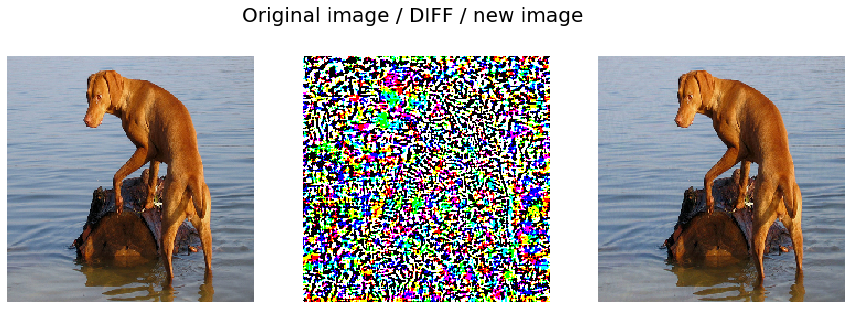

Hacked predictions
vizsla 	 0.002378
Rhodesian_ridgeback 	 0.942216

CPU times: user 532 ms, sys: 28 ms, total: 560 ms
Wall time: 569 ms


In [10]:
%%time
new_cat = 'Rhodesian_ridgeback'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

ridgeback_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                                   preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), ridgeback_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, ridgeback_img[None])
print()

### What does the network says for the mask?

Nothing. The most probable class is still <4%

In [11]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((vizsla_img - ridgeback_img[None]).copy())), 5)

[[('n03590841', "jack-o'-lantern", 0.0372888),
  ('n04286575', 'spotlight', 0.034142777),
  ('n03637318', 'lampshade', 0.03412751),
  ('n03196217', 'digital_clock', 0.031185374),
  ('n03729826', 'matchstick', 0.029518709)]]

In [12]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((ridgeback_img[None] - vizsla_img).copy())), 5)

[[('n03590841', "jack-o'-lantern", 0.03892302),
  ('n03637318', 'lampshade', 0.03442796),
  ('n04286575', 'spotlight', 0.032851886),
  ('n03196217', 'digital_clock', 0.028835155),
  ('n03666591', 'lighter', 0.027664024)]]

## What about a doberman?

Originally 0.5% probability for doberman!

Original predictions:
vizsla 	 0.519496
Doberman 	 0.005825


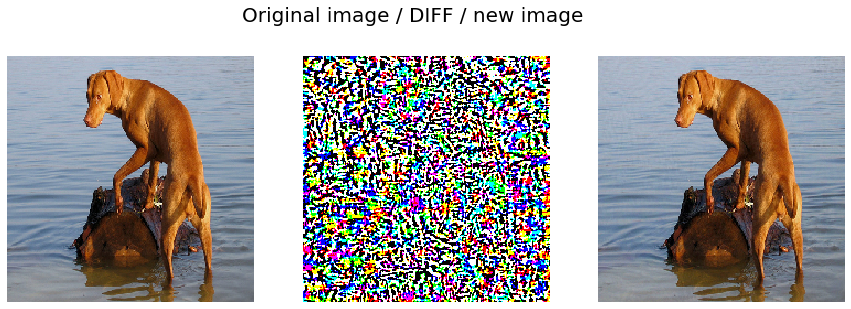

Hacked predictions
vizsla 	 0.012999
Doberman 	 0.531592


In [13]:
new_cat = 'Doberman'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

doberman_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                                  preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), doberman_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, doberman_img[None])

In [14]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((vizsla_img - doberman_img[None]).copy())), 5)

[[('n03590841', "jack-o'-lantern", 0.03579553),
  ('n04286575', 'spotlight', 0.03245119),
  ('n03196217', 'digital_clock', 0.032239273),
  ('n03666591', 'lighter', 0.031777628),
  ('n03729826', 'matchstick', 0.030491743)]]

# Easy... brown bear? :)

Original predictions:
vizsla 	 0.519496
brown_bear 	 1.4e-05


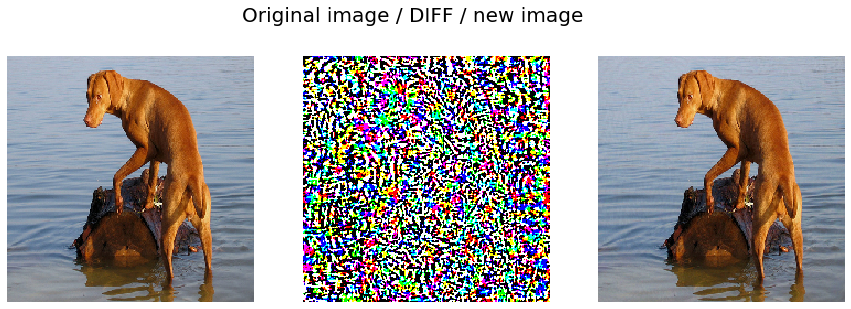

Hacked predictions
vizsla 	 0.002289
brown_bear 	 0.354838

What are the top predictions now?


[[('n02132136', 'brown_bear', 0.35483795),
  ('n02134084', 'ice_bear', 0.16847047),
  ('n02363005', 'beaver', 0.11665347),
  ('n02093991', 'Irish_terrier', 0.07079785),
  ('n02442845', 'mink', 0.044936106)]]

In [15]:
new_cat = 'brown_bear'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

bear_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                              preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), bear_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, bear_img[None])
print('\nWhat are the top predictions now?')
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(bear_img[None].copy())), 5)

# It worked again.. iPod?

Original predictions:
vizsla 	 0.519496
iPod 	 0.0


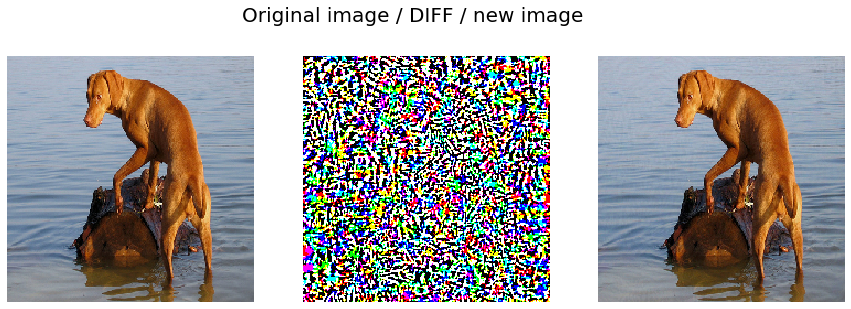

Hacked predictions
vizsla 	 0.008921
iPod 	 0.000702


[[('n02093991', 'Irish_terrier', 0.1334435),
  ('n02356798', 'fox_squirrel', 0.091195524),
  ('n02363005', 'beaver', 0.051758494),
  ('n02096051', 'Airedale', 0.04962704),
  ('n02134084', 'ice_bear', 0.029664323)]]

In [16]:
new_cat = 'iPod'
print('Original predictions:')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, vizsla_img)

ipod_img = generate_new_image(new_cat, 2, vgg16_model, vizsla_img, 
                                  preprocess_input_VGG16, original_img_mask_preds)
plot_img_diff(vizsla_img[0].astype(np.uint8), ipod_img)

print('Hacked predictions')
get_preds('vizsla', new_cat, preprocess_input_VGG16, vgg16_model, ipod_img[None])
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(ipod_img[None].copy())), 5)

We just managed to screw up original predictions, but did not reach iPod. But.. ice bear? beaver?

# Change network to VGG19

Until now we optimized the masks on the VGG16 network and also fooled the same network. What if we cannot optimize out strategy on the network that we want to fool?

In [17]:
vgg19_model = VGG19()
decode_predictions(vgg19_model.predict(preprocess_input_VGG19(vizsla_img.copy())), top=5)

[[('n02100583', 'vizsla', 0.8596322),
  ('n02087394', 'Rhodesian_ridgeback', 0.07811302),
  ('n02090379', 'redbone', 0.043273132),
  ('n02093991', 'Irish_terrier', 0.005052105),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.0033731614)]]

In [18]:
decode_predictions(vgg19_model.predict(preprocess_input_VGG19((ridgeback_img[None]).copy())), top=5)

[[('n02087394', 'Rhodesian_ridgeback', 0.566645),
  ('n02100583', 'vizsla', 0.29803875),
  ('n02090379', 'redbone', 0.08654221),
  ('n02107142', 'Doberman', 0.014622714),
  ('n02093991', 'Irish_terrier', 0.0078508975)]]

In [19]:
decode_predictions(vgg19_model.predict(preprocess_input_VGG19((doberman_img[None]).copy())), top=5)

[[('n02100583', 'vizsla', 0.42288214),
  ('n02087394', 'Rhodesian_ridgeback', 0.248066),
  ('n02107142', 'Doberman', 0.10929805),
  ('n02090379', 'redbone', 0.060368173),
  ('n02093991', 'Irish_terrier', 0.035443094)]]

Doberman does not work. What if we increase the mask's weight?

[[('n02107142', 'Doberman', 0.16129376),
  ('n02087394', 'Rhodesian_ridgeback', 0.112665854),
  ('n02093991', 'Irish_terrier', 0.09056211),
  ('n02093428', 'American_Staffordshire_terrier', 0.071112685),
  ('n02100583', 'vizsla', 0.06725722)]]

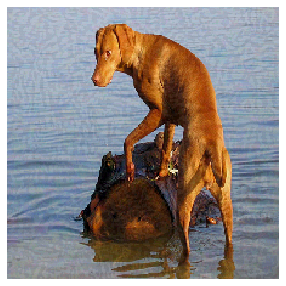

In [20]:
new_img = ((doberman_img[None] - vizsla_img)*3 + vizsla_img).clip(0,255).copy().astype(np.uint8)
plt.imshow(new_img[0].astype(np.uint8))
plt.axis('off')
decode_predictions(vgg19_model.predict(preprocess_input_VGG19(new_img.copy())), top=5)

# It works again. But VGG16 & VGG19 really similar.

# Let's try ResNet50!

<img src="https://www.researchgate.net/profile/Masoud_Mahdianpari/publication/326421398/figure/fig4/AS:649352863301634@1531829195262/Schematic-diagram-of-a-VGG16-and-b-VGG19-models.png">

**VGG16 (a) and VGG19 (b)**

Credits: Masoud Mahdianpari et al, 2018

<img src="https://imgur.com/nyYh5xH.jpg">

**VGG vs ResNet**

Credits: https://www.kaggle.com/keras/resnet50

In [21]:
resnet50_model = ResNet50()
decode_predictions(resnet50_model.predict(preprocess_input_resnet50(vizsla_img.copy())), top=5)

[[('n02100583', 'vizsla', 0.8938405),
  ('n02087394', 'Rhodesian_ridgeback', 0.030327965),
  ('n02093991', 'Irish_terrier', 0.025840387),
  ('n02090379', 'redbone', 0.016793795),
  ('n02504013', 'Indian_elephant', 0.008863223)]]

In [22]:
decode_predictions(resnet50_model.predict(preprocess_input_resnet50((ridgeback_img[None]).copy())), top=5)

[[('n02100583', 'vizsla', 0.7339929),
  ('n02087394', 'Rhodesian_ridgeback', 0.13927934),
  ('n02093991', 'Irish_terrier', 0.035683487),
  ('n02090379', 'redbone', 0.029688379),
  ('n02504013', 'Indian_elephant', 0.026705746)]]

[[('n02087394', 'Rhodesian_ridgeback', 0.46834737),
  ('n02100583', 'vizsla', 0.43993178),
  ('n02090379', 'redbone', 0.025647448),
  ('n02108089', 'boxer', 0.019824974),
  ('n02093991', 'Irish_terrier', 0.01960541)]]

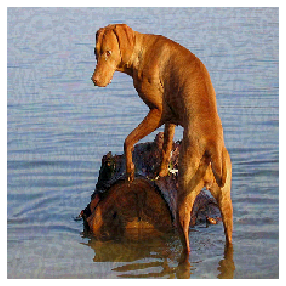

In [23]:
new_img = ((ridgeback_img[None] - vizsla_img)*3 + vizsla_img).clip(0,255).copy().astype(np.uint8)
plt.imshow(new_img[0].astype(np.uint8))
plt.axis('off')
decode_predictions(resnet50_model.predict(preprocess_input_resnet50(new_img.copy())), top=5)

In [24]:
decode_predictions(resnet50_model.predict(preprocess_input_resnet50((bear_img[None]).copy())), top=5)

[[('n02093991', 'Irish_terrier', 0.2500421),
  ('n02100583', 'vizsla', 0.23263873),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.1777217),
  ('n02504013', 'Indian_elephant', 0.1126349),
  ('n02087394', 'Rhodesian_ridgeback', 0.06376837)]]

[[('n02132136', 'brown_bear', 0.37340438),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.065971226),
  ('n02115641', 'dingo', 0.06417671),
  ('n02093991', 'Irish_terrier', 0.053259034),
  ('n02442845', 'mink', 0.048445385)]]

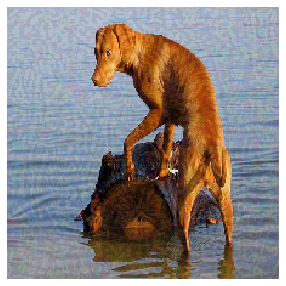

In [25]:
new_img = ((bear_img[None] - vizsla_img)*4 + vizsla_img).clip(0,255).copy().astype(np.uint8)
plt.imshow(new_img[0].astype(np.uint8))
plt.axis('off')
decode_predictions(resnet50_model.predict(preprocess_input_resnet50(new_img.copy())), top=5)

In [26]:
!wget -q -O panda.jpg https://www.zoo-berlin.de/fileadmin/_processed_/8/3/csm_Meng_Meng_Baby_1_0b7fe14b2b.jpg

panda_img = load_img('panda.jpg', target_size=(224, 224))
panda_img = img_to_array(panda_img)[None]

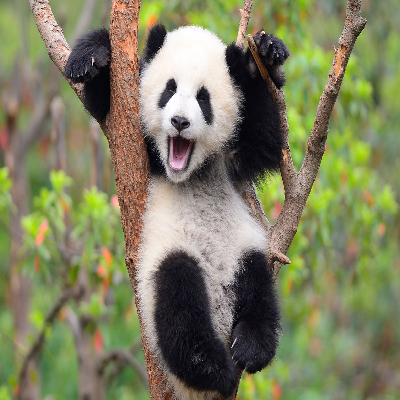

In [27]:
load_img('panda.jpg', target_size=(400, 400))

In [28]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((panda_img).copy())), top=5)

[[('n02510455', 'giant_panda', 0.83484024),
  ('n02509815', 'lesser_panda', 0.029610783),
  ('n02412080', 'ram', 0.020298257),
  ('n02483362', 'gibbon', 0.018874317),
  ('n02500267', 'indri', 0.015583708)]]

Why did they use panda $\to$ gibbon on that famous example?

# Conclusion

Using a simple adversarial attack strategy we can fool a CNN. The fooling strategy seems to generalize over different networks. Most probably because all the three networks that we tried were trained on ImageNet data. Althoug they have different architecture, they all were trained to perform the same task, to mimic the same/similar function.